In [1]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2
from scipy.stats import spearmanr,pearsonr

2022-08-11 16:43:39.906699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 16:43:39.906720: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
#loading yeast groundtruth 1 data
#yeast=open("../yeast_residual_data_full_1000_gt_1.txt","r")



#yeast data read 
#L=[]
#A=[]
#B=[]
#for i in range(0,1000):
    #line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    #line=yeast.readline()
    #l = [j for j in line.split()]
    #L.append([int(i) for i in l])
    #line=yeast.readline()
    #a = [j for j in line.split()]
    #A.append([float(i) for i in a])
    #line=yeast.readline()
    #b = [j for j in line.split()]
    #B.append([float(i) for i in b])
#dataset_0 = [i for i in zip(L,A,B)]


In [2]:
import sys
#First argument for the number of runs, second for the initial run
j=int(sys.argv[2])
n=int(sys.argv[1])

ValueError: invalid literal for int() with base 10: '/home/aravind/.local/share/jupyter/runtime/kernel-5f3f6828-72ab-4468-b147-f62d45773a13.json'

In [ ]:
f=open("Humansindp.txt","a")

In [3]:
#defining the class MDN
class MDN_module(tf.keras.Model):
#neurons changed from 15 to 20, changed it back to 15 
    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\",name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [4]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
        indices_1 = [i for i, x in enumerate(x_test) if x == 1]
        indices_0 = [i for i, x in enumerate(x_test) if x == 0]
        indices_2=[i for i, x in enumerate(x_test) if x == -1]
        mu_0=np.mean(y_test[indices_0])
        mu_1=np.mean(y_test[indices_1])
        mu_2=np.mean(y_test[indices_2])
        sigma_0=np.std(y_test[indices_0])
        sigma_1=np.std(y_test[indices_1])
        sigma_2=np.std(y_test[indices_2])
        y_mean=np.zeros((len(y_test),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        y_mean[indices_2]=mu_2
        y_std=np.zeros((len(y_test),1))
        y_std[indices_1]=sigma_1
        y_std[indices_0]=sigma_0
        y_std[indices_2]=sigma_2
        alpha=np.ones((len(y_mean),1))
        return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [15]:
def compute_loss(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        #return np.array(nlcor.nlcor(P,Q)[0])[0]
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [5]:
def compute_loss_y_pred(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(x_test) if x == 1]
        indices_0 = [i for i, x in enumerate(x_test) if x == 0]
        indices_2=[i for i, x in enumerate(x_test) if x == -1]
        mu_0=np.mean(y_test[indices_0])
        mu_1=np.mean(y_test[indices_1])
        mu_2=np.mean(y_test[indices_2])
        sigma_0=np.std(y_test[indices_0])
        sigma_1=np.std(y_test[indices_1])
        sigma_2=np.std(y_test[indices_2])
        y_mean=np.zeros((len(y_test),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        y_mean[indices_2]=mu_2
        y_std=np.zeros((len(y_test),1))
        y_std[indices_1]=sigma_1
        y_std[indices_0]=sigma_0
        y_std[indices_2]=sigma_2
        return y_mean.reshape((len(y_mean),))
        
        

In [6]:
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else:
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [7]:
def LinearLABData():
    """ Generate the linear data 
    """
    L = np.random.binomial(1,0.5,1000)  
    beta0 = np.ones(1000)-0.4
    #beta1 = 0.5
    beta1=3
    beta2= 0.3
    beta3=0.8
    #eps0 = np.random.standard_normal(1000)
    #eps1 = np.random.standard_normal(1000)
    eps0 = np.random.normal(0,1,1000)
    eps1 = np.random.normal(0,1,1000)
    A = beta0 + beta1*L + eps0
    #B=beta2+beta3*np.sin(A)+eps1
    B = beta2+ beta3*A + eps1 
    plt.scatter(A,B)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L,A,B]

In [8]:
fo=open("../LinearDifferentvalues/testing_writingvalues_humans.txt", "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,144):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [9]:
fer=open("../LinearDifferentvalues/dataset_params_humans_indp.txt","r")
dataset_names=[]
for i in range(0,144):
    line=fer.readline()
    line="_".join(line.split())
    dataset_names.append(line)
fer.close()

In [ ]:
#loading yeast groundtruth 1 data
#yeast=open("../../yeast_residual_data_full_62k_gt1.txt","r")



#yeast data read 
#L=[]
#A=[]
#B=[]
#for i in range(0,62296):
    #line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    #line=yeast.readline()
    #l = [j for j in line.split()]
    #L.append([int(i) for i in l])
    #line=yeast.readline()
    #a = [j for j in line.split()]
    #A.append([float(i) for i in a])
    #line=yeast.readline()
    #b = [j for j in line.split()]
    #B.append([float(i) for i in b])
#dataset_yeast = [i for i in zip(L,A,B)]


In [ ]:
#read_file = open("indicesUsedIndependent.pkl", "rb")
#indices=pickle.load(read_file)
#read_file.close()

In [ ]:
#read_file = open("../../10kyeast_ind.pkl", "rb")
#dataset_yeast10k=pickle.load(read_file)
#read_file.close()

In [ ]:
#dataset_yeast10k=[dataset_yeast[q] for q in indices]

In [9]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(abs(i) < abs(original) for i in loss_list)/len(loss_list)
    
    

In [11]:
def compute_third_testloss(A,B):
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference

#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
    withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
    y_pred = mdn_PQ.predict(A)
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    return -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [12]:
def calculate_difference(L,A,B):
    return compute_third_testloss(reshapevar(A),np.array(B))-compute_third_testloss(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),np.array(B))
    

In [13]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    indices_2 = [i for i, x in enumerate(L) if x == -1]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        mod_indices_2=random.sample(indices_2,len(indices_2))
        for i in range(len(indices_2)):
            B_dist_temp[indices_2[i]]=B[mod_indices_2[i]]
        loss.append(calculate_difference(L,A,B_dist_temp))
    return loss

In [30]:
i=83
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])

In [16]:
#for i in range(j,j+n): 
i=83
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])
shuffles=100
A_shuffle=np.copy(A)
B_shuffle=np.copy(B)
#print("Original",B_shuffle)
loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
true_LA=compute_loss(L,A,True)
true_LB=compute_loss(L,B,True)
true_LBresidual=calculate_difference(L,A,B)
LA_p=calculate_pvalue(true_LA,loss_list_LA)
LB_p=calculate_pvalue(true_LB,loss_list_LB)
AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)
    #f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
    #pickle_items=[loss_list_LA,loss_list_LB,loss_list_Bresidual,true_LA,true_LB,true_LBresidual,LA_p,LB_p,AB_p]
    #file_name=str(dataset_names[i])+".pkl"
    #open_file = open("./DLresultspickle1000shuffle/"+file_name, "wb")
    #pickle.dump(pickle_items, open_file)
    #open_file.close()

2022-08-11 16:47:15.474395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-11 16:47:15.474429: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-11 16:47:15.474444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (birds05-Precision-Tower-3620): /proc/driver/nvidia/version does not exist
2022-08-11 16:47:15.474647: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
print(LA_p)
print(LB_p)
print(AB_p)

0.0
0.0
0.0


In [16]:
true_LBresidual

0.004401207

In [17]:
loss_list_Bresidual

[0.029548883,
 0.032421112,
 0.050994396,
 0.035209656,
 0.030960202,
 0.03243625,
 0.032122135,
 0.032809496,
 0.038663983,
 0.03698778,
 0.024021268,
 0.023202896,
 0.036349535,
 0.01995778,
 0.022079825,
 0.044232607,
 0.046394944,
 0.03815019,
 0.043589115,
 0.024092793,
 0.027285933,
 0.024016619,
 0.03387344,
 0.034905076,
 0.0167377,
 0.026663303,
 0.044727206,
 0.016676188,
 0.057854176,
 0.030917764,
 0.035392046,
 0.02310574,
 0.03134358,
 0.035511732,
 0.04341674,
 0.036971807,
 0.047695756,
 0.033201575,
 0.04471135,
 0.048140883,
 0.03743565,
 0.04133272,
 0.049679995,
 0.03001833,
 0.026278615,
 0.03297293,
 0.02217269,
 0.04886639,
 0.045849323,
 0.041635036,
 0.045084596,
 0.028300762,
 0.031107426,
 0.033603787,
 0.0246135,
 0.05253339,
 0.03099978,
 0.030766368,
 0.028612852,
 0.03205526,
 0.033419013,
 0.036669016,
 0.061808705,
 0.038002253,
 0.026152015,
 0.03526318,
 0.030886054,
 0.039960027,
 0.031679034,
 0.030995727,
 0.025317788,
 0.038956285,
 0.035019875,
 

In [33]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=100,  batch_size=64,verbose=0)
A_sorted=np.array(sorted(A))
y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A_sorted.reshape(-1,1)],axis=1))


In [42]:
alpha,mu,sigma = slice_parameter_vectors(y_pred)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [43]:
loss

3.4494355

Text(0.5, 1.0, 'Original data with the added information of L')

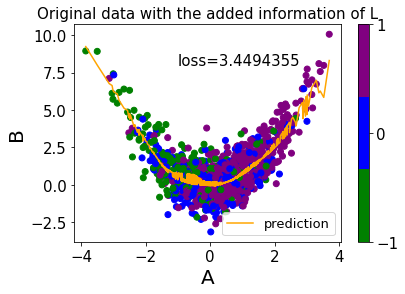

In [110]:
import matplotlib
colors = ['green','blue','purple']

plt.scatter(A, B, c=L, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar(ticks=np.arange(np.min(L), np.max(L) + 1))
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title

plt.plot(A_sorted,y_pred[:,1],color='orange',label='prediction')
plt.legend()
plt.text(-1,8,'loss=%s'%(loss),fontsize=15)
plt.xlabel("A")
plt.ylabel("B")
plt.title("Original data with the added information of L")

In [16]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()

mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=B.T,epochs=100,  batch_size=64,verbose=0)
y_pred = mdn_PQ.predict(reshapevar(A))

Text(0.5, 1.0, 'Original data without the added information L')

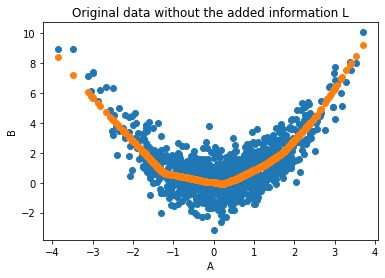

In [17]:
plt.scatter(A,B)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Original data without the added information L")


In [18]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == 0]
indices_2 = [i for i, x in enumerate(L) if x == -1]
B_dist_temp=np.zeros(len(B))
mod_indices_1=random.sample(indices_1,len(indices_1))
for i in range(len(indices_1)):
    B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

mod_indices_0=random.sample(indices_0,len(indices_0))
for i in range(len(indices_0)):
    B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
mod_indices_2=random.sample(indices_2,len(indices_2))
for i in range(len(indices_2)):
    B_dist_temp[indices_2[i]]=B[mod_indices_2[i]]

In [19]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B_dist_temp.T,epochs=100,  batch_size=64,verbose=0)
y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


Text(0.5, 1.0, 'Permuted data with the added information L')

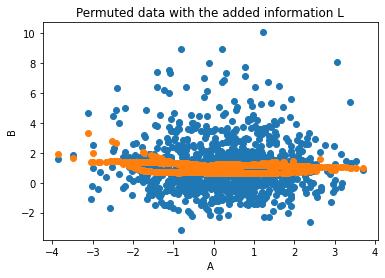

In [20]:
plt.scatter(A,B_dist_temp)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Permuted data with the added information L")

In [21]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=B_dist_temp.T,epochs=100,  batch_size=64,verbose=0)
y_pred = mdn_PQ.predict(reshapevar(A))

Text(0.5, 1.0, 'Permuted data without the added information L')

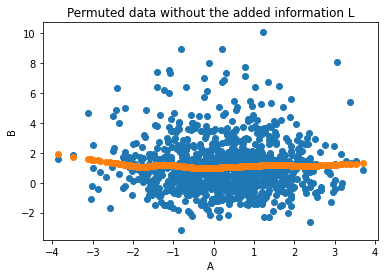

In [22]:
plt.scatter(A,B_dist_temp)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Permuted data without the added information L")

In [ ]:
f.close()